# Airbnb price prediction

In [1]:
import pandas as pd
import numpy as np
from statistics import median
import math
from math import sin, cos, sqrt, atan2, radians
from scipy import stats
from random import sample
from collections import Counter

import matplotlib.pyplot as plt
from pylab import plot, axes
import seaborn as sns

# for text treatment
import unidecode
from stemming.porter2 import stem

# for exportation
import csv

from datetime import datetime, timedelta

# sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
import category_encoders as ce

# Boosting algorithms
import xgboost as xgb
import catboost as cb

# NN
from tensorflow import keras
from keras import optimizers, regularizers, callbacks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


# 0. Importing the data

Two files:
- train_airbnb.csv contains the initial basic features available on Kaggle and the variable price from which to learn
- test_airbnb.csv contains new observations whose price is unknown

In [142]:
train = pd.read_csv("train_airbnb.csv")
X_to_predict = pd.read_csv("test_airbnb.csv")

indices = X_to_predict.id.to_list()

train.set_index('id', inplace=True)
X_to_predict.set_index('id', inplace=True)

The train datasets contains both the predictor variables (X_train) and the price (Y_train). To submit to Kaggle we will need to predict on X_to_predict, using what we have learned on train, so we will need X_to_predict to have the same columns as X_train (X_to_predict does not contain the price). We won't group them because in some cases we will be doing some operations (e.g. dropping rows) on train that we don't want to do on X_to_predict.

In [143]:
# Have a look at the first rows
print(f"The train dataset contains {len(train)} Airbnb listings and the test one contains {len(X_to_predict)}.")
print(f"In total there are {len(train.columns)} predictors.")

# Set options for visualisation
pd.set_option('display.max_columns', len(train.columns)) # to see all the columns
pd.set_option('display.max_rows', 10000) # to see more lines

train.head(2)

The train dataset contains 44197 Airbnb listings and the test one contains 10886.
In total there are 57 predictors.


,name,description,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_since,host_seniority,host_response_time,host_response_rate,host_listings_count,host_verifications,neighbourhood_cleansed,city,zipcode,country,latitude_airbnb,longitude_airbnb,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,geolocation,features,geopoint_announce,department
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10534791,Appartement 2P pour 4 pers. BERCY,Cet appartement est idéalement situé à 10 minu...,Le quartier est animé sans être étouffant. Il ...,NaN,Lignes de métro 6 et 8 à moins de 3 minutes. ...,Vous aurez accès à l'ensemble du logement.,NaN,NaN,22523453,2014-10-14T00:00:00.000Z,1805.0,NaN,NaN,1.0,"email,phone,reviews",Reuilly,Paris,75012.0,France,48.841013,2.392880,Apartment,Entire home/apt,4.0,1.0,1.0,2.0,Real Bed,"TV,Internet,Wireless Internet,Kitchen,Buzzer/w...",55.0,0_no_deposit,1_]0-30],1.0,0.0,3.0,1125.0,3 weeks ago,7.0,11.0,11.0,11.0,2.0,2016-03-30,2016-06-20,80.0,7.0,8.0,7.0,8.0,10.0,8.0,strict,0.16,"48.8410132928,2.39288035231",Host Has Profile Pic,POINT(2.3928803523142053 48.841013292835235),Paris
16001259,"Cosy 2 pièces in Paris 12ème, Porte Dorée","Mon logement est proche du bois de Vincennes, ...",NaN,NaN,NaN,NaN,NaN,NaN,37202116,2015-07-01T00:00:00.000Z,1545.0,NaN,NaN,1.0,phone,Reuilly,Paris,75012.0,France,48.840806,2.408244,Apartment,Entire home/apt,4.0,1.0,1.0,2.0,Real Bed,"TV,Wireless Internet,Kitchen,Smoking allowed,E...",53.0,0_no_deposit,0_no_deposit,1.0,0.0,7.0,14.0,5 months ago,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,"48.8408064183,2.40824414207",Host Has Profile Pic,POINT(2.4082441420748024 48.84080641832087),Paris


In [144]:
train.columns

Index(['name', 'description', 'neighborhood_overview', 'notes', 'transit',
       'access', 'interaction', 'house_rules', 'host_id', 'host_since',
       'host_seniority', 'host_response_time', 'host_response_rate',
       'host_listings_count', 'host_verifications', 'neighbourhood_cleansed',
       'city', 'zipcode', 'country', 'latitude_airbnb', 'longitude_airbnb',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'cancel

In [145]:
# With host_since and host_seniority, we can know that the data was scrapped on September the 23rd of 2019
scrapping_date = pd.to_datetime(pd.to_datetime(train.host_since.iloc[0]) + timedelta(days=train.host_seniority.iloc[0]))
scrapping_date = scrapping_date.replace(tzinfo=None)
print("The data was scrapped on the", scrapping_date)

The data was scrapped on the 2019-09-23 00:00:00


# 1. Data preprocessing

## 1.1. Dropping everything that seems irrelevant at first view

In [146]:
# For the moment we won't do any Natural Language Processing, so we drop columns that contain text
train.drop(columns=['name', 'neighborhood_overview', 'notes', 'transit',
                    'access', 'interaction', 'house_rules'], inplace=True)

# We also want to drop columns that don't seem to be helpful for price prediction
train.drop(columns=['host_id', 'calendar_updated',
                    'availability_30', 'availability_60', 'availability_90', 'availability_365'],
           inplace=True)

# Other columns may be redundant because of correlation with other columns
train.drop(columns=['host_since', 'reviews_per_month'], inplace=True)

In [147]:
# Same for X_to_predict
X_to_predict.drop(columns=['name', 'neighborhood_overview', 'notes', 'transit',
                           'access', 'interaction', 'house_rules', 'host_id', 'calendar_updated',
                           'availability_30', 'availability_60', 'availability_90', 'availability_365',
                           'host_since', 'reviews_per_month'], inplace=True)

As for variables related to location, we have a few ones: 
* **`country`** is always either "France" or nan, so it's not useful.
* similarly for **`department`**: 'Hauts-de-Seine', 'Paris', 'Seine-Saint-Denis' or 'Val-de-Marne', so it's useless.
* `geolocation` and `geopoint_announce` contain the same information as **`latitude_airbnb`** and **`longitude_airbnb`**. Since for future model implementation it is better to have numerical columns (i.e. of type float64) instead of tuples, we keep the latter as two separate columns.
* we still have `neighbourhood_cleansed`, `city` and `zipcode` left. Let's see what do we keep.

In [148]:
print("neighbourhood_cleansed has", train.neighbourhood_cleansed.isna().sum(), "missing values.")
print("city has", train.city.isna().sum(), "missing values.")
print("zipcode has", train.zipcode.isna().sum(), "missing values.")

print("neighbourhood_cleansed has", len(set(train.neighbourhood_cleansed)), "unique values.")
print("city has", len(set(train.city)), "unique values.")
print("zipcode has", len(set(train.zipcode)), "unique values.")

print("After some cleaning, zipcode would have", len(set(train.zipcode)) - train.zipcode.isna().sum(), "unique values left.")

neighbourhood_cleansed has 0 missing values.
city has 23 missing values.
zipcode has 12 missing values.
neighbourhood_cleansed has 20 unique values.
city has 100 unique values.
zipcode has 70 unique values.
After some cleaning, zipcode would have 58 unique values left.


Conclusions:
* **`neighbourhood_cleansed`** is very nice! It has 20 unique values which correspond to the 20 arrondissements of Paris (it was already cleaned by the source who did the web-scrapping), and it does not have any missing value!
* `city` has a few missing values and is really messy. We also see it has more unique values, so at first view we could think it contains some more granular level, but in fact most of them are just the numbers of arrondissements (for instance 'Paris-7E-Arrondissement'), which  means that for most properties we won't be able to go into more detail than what we got with neighbourhood_cleansed. Hence we will discard this variable.
* `zipcode` seems interesting at first view. After some small cleaning (only 12 missing values) there would be 55 unique values. But even if it's a more granular level than neighborhood cleansed, it won't be more precise than longitude and lattitude, so won't keep it. <br>

Therefore, we will try different configurations, one with coordinates and the other with neighborhood_cleansed. Our utlimate goal here is to compare the performance of various models, decide which one is best, and try to understand why.

In [149]:
# variables related to location
train.drop(columns=['country','geolocation', 'geopoint_announce', 'city', 'department', 'zipcode'], inplace=True)
X_to_predict.drop(columns=['country','geolocation', 'geopoint_announce', 'city', 'department', 'zipcode'], inplace=True)

In [150]:
# We would also like to drop every other column that contains too many missing values
train.isna().sum() / len(train) * 100

description                     0.009050
host_seniority                  0.022626
host_response_time             33.371043
host_response_rate             33.371043
host_listings_count             0.022626
host_verifications              0.081453
neighbourhood_cleansed          0.000000
latitude_airbnb                 0.002263
longitude_airbnb                0.002263
property_type                   0.002263
room_type                       0.002263
accommodates                    0.002263
bathrooms                       0.314501
bedrooms                        0.199109
beds                            0.128968
bed_type                        0.002263
amenities                       0.726294
price                           0.099554
security_deposit                0.002263
cleaning_fee                    0.002263
guests_included                 0.002263
extra_people                    0.002263
minimum_nights                  0.002263
maximum_nights                  0.002263
number_of_review

Here, apart from `host_response_time`, `host_response_rate`, and the `review_scores`, the other variables contain few missing values! So before moving forward, we need to decide what we want to do with these variables. <br>
It is fair to assume that the review scores are quiet important when choosing an Airbnb, and so that all of these variables have an influence on the price. Furthermore, dropping all rows where a value is missing would result in loosing a lot of information, because we see that all of these properties have all (or nearly all) the other columns filled in.
Consequently, we will keep these variables for now, and see how to deal with them in the next subsection.

## 1.2. Cleaning the variables, one-by-one

#### host_response_time

As we just saw mentionned, this is a variable with a lot of missing values.

In [151]:
set(train.host_response_time)

{'a few days or more',
 nan,
 'within a day',
 'within a few hours',
 'within an hour'}

In [152]:
print("Proportion of missing values:", round((train.host_response_time.isna().sum()/len(train))*100, 2), "%.")

Proportion of missing values: 33.37 %.


In [153]:
tmp = train[['host_response_time', 'number_of_reviews']][train.host_response_time.isna()]
tmp = tmp[tmp.host_response_time.isna()]
tmp = tmp[tmp.number_of_reviews == 0]
print("Among the missing values,", round(len(tmp)/sum(train.host_response_time.isna())*100, 2), "% have 0 reviews.")

Among the missing values, 47.21 % have 0 reviews.


Indeed, this may be the case of posted properties that hadn't yet received any review at the moment when the web-scraping was made. So in fact it's not really a "missing" value, in the sense that it still hasn't had the opportunity to be determined. We will hence replace the nan by undetermined.

In [154]:
train.host_response_time.fillna("undetermined", inplace=True)
X_to_predict.host_response_time.fillna("undetermined", inplace=True)

None
train.host_response_time.replace({"within an hour": "0_within_an_hour",
                                  "within a few hours": "1_within_a few_hours ",
                                  "within a day": "2_within_a_day",
                                  "a few days or more": "3_a_few_days_or_more"}, inplace=True)
train.host_response_time.value_counts(normalize=True)

undetermined             0.333710
0_within_an_hour         0.303188
1_within_a few_hours     0.173179
2_within_a_day           0.160124
3_a_few_days_or_more     0.029798
Name: host_response_time, dtype: float64

#### host_response_rate

In [155]:
print("Proportion of missing values:", round((train.host_response_rate.isna().sum()/len(train))*100, 2), "%.")

Proportion of missing values: 33.37 %.


We also have about a third of the values which are missing for this variable. <br> The thing is that this is a numerical variable, so we can't simply replace the nan by 0. Instead, if we want to replace the nan by undetermined as we did before, we need to convert it to a categorical variable.

In [156]:
train.host_response_rate.describe()

count    29448.000000
mean        91.571007
std         20.453736
min          0.000000
25%         95.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: host_response_rate, dtype: float64

In [157]:
print("Proportion of hosts with 100% response rate:", 
      round(len(train[train.host_response_rate == 100]) / (len(train.host_response_rate) - train.host_response_rate.isna().sum())*100, 2), "%.")

Proportion of hosts with 100% response rate: 70.37 %.


We see that most of the hosts always respond all the time. This will affect the way we split the variable.

In [158]:
# Splitting into four categories
train.host_response_rate = pd.cut(train.host_response_rate, 
                                  bins=[0, 51, 96, 99, 100],
                                  labels=['0_0-50%', '1_51-95%', '2_96-99%', '3_100%'], # the variable only has integer values
                                  include_lowest=True)

train.host_response_rate = train.host_response_rate.astype('str') # we need to convert to string
train.host_response_rate.replace('nan', '4_undetermined', inplace=True)

# For X_to_predict
X_to_predict.host_response_rate = pd.cut(X_to_predict.host_response_rate, 
                                   bins=[0, 51, 96, 99, 100],
                                   labels=['0_0-50%', '1_51-95%', '2_96-99%', '3_100%'],
                                   include_lowest=True)

X_to_predict.host_response_rate = X_to_predict.host_response_rate.astype('str') # we need to convert to string
X_to_predict.host_response_rate.replace('nan', '4_undetermined', inplace=True)

# Results
train.host_response_rate.value_counts()

3_100%            20724
4_undetermined    14749
1_51-95%           5862
0_0-50%            1862
2_96-99%           1000
Name: host_response_rate, dtype: int64

#### host_verifications

Intuitively this doesn't seem like a crucial variable. Maybe a host with more verifications is more worried about renting, but that's all. We will simply keep the number of verifications.

In [159]:
train.host_verifications.head(3)

id
10534791                                 email,phone,reviews
16001259                                               phone
17763072    email,phone,linkedin,reviews,jumio,government_id
Name: host_verifications, dtype: object

In [160]:
# Again, we will first replace nan by median of number of verifications
med = median([len(str(i).split(",")) for i in train.host_verifications])
train_verificatons = list()
for i in train.host_verifications:
    if str(i) == "nan":
        train_verificatons.append(med)
    else:
        train_verificatons.append(len(str(i).split(",")))
        
train.host_verifications = train_verificatons
        

# Same for X_to_predict
med = median([len(str(i).split(",")) for i in X_to_predict.host_verifications])
X_to_predict_verificatons = list()
for i in X_to_predict.host_verifications:
    if str(i) == "nan":
        X_to_predict_verificatons.append(med)
    else:
        X_to_predict_verificatons.append(len(str(i).split(",")))
        
X_to_predict.host_verifications = X_to_predict_verificatons

#### latitude_airbnb / longitude_airbnb

In [161]:
print("For latitude we miss id", train.index[train.latitude_airbnb.isna()][0])
print("For longitude we miss id", train.index[train.longitude_airbnb.isna()][0])

# We are missing the coordinates for the same host (in fact it has nothing so we will simply drop it)
train = train[pd.notnull(train["longitude_airbnb"])]
train = train[pd.notnull(train["latitude_airbnb"])]

For latitude we miss id 3539728
For longitude we miss id 3539728


#### property_type

In [162]:
# No NaN values
train.property_type.isna().sum()

0

In [163]:
train.property_type.value_counts(normalize=True) * 100

Apartment             95.458865
Loft                   1.058919
House                  1.043081
Bed & Breakfast        0.742149
Condominium            0.538510
Other                  0.307720
Boutique hotel         0.221740
Townhouse              0.142547
Guesthouse             0.126708
Dorm                   0.110870
Hostel                 0.054304
Boat                   0.054304
Serviced apartment     0.047516
Cabin                  0.029414
Villa                  0.027152
Timeshare              0.011313
Bungalow               0.004525
Camper/RV              0.004525
Igloo                  0.004525
Cave                   0.004525
Tipi                   0.002263
Earth House            0.002263
Chalet                 0.002263
Name: property_type, dtype: float64

This is a harder one to treat! Apart from the level "apartment", all other levels rarely occur.
We think this variable is important to determine the price, though, so let's try to deal with it. <br>
The usual approach in this cases where we have plenty of categories with few observations is to combine levels with similarities. Here a loft is a type of apartment, and a villa is a type of house, for instance...
Of course, if we do this we are losing detail, because a loft is usually more luxurious than an apartment. But we can also think that with so many livings having been classified as "Apartment", some of them must also be more luxurious, and so the information about this differentiation has, in reality, already been lost. Besides, with so few observations we don't have many alternatives.

In [164]:
# Let's do some replacement
dic = {
    "Loft": "Apartment",
    "Bed & Breakfast": "Hotel",
    "Condominium": "Apartment",
    "Boutique hotel": "Hotel",
    "Townhouse": "House",
    "Guesthouse": "House",
    "Dorm": "Apartment",
    "Hostel": "Hotel",
    "Boat": "Other",
    "Serviced apartment": "Apartment",
    "Cabin": "House",
    "Villa": "House",
    "Timeshare": "Apartment",
    "Cave": "Other",
    "Camper/RV": "Other",
    "Bungalow": "House",
    "Igloo": "Other",
    "Earth House": "House",
    "Chalet": "House",
    "Tipi": "Other"
}

tmp = train.copy()
tmp.replace({"property_type": dic}, inplace=True)

In [165]:
# new counts
tmp.property_type.value_counts(normalize=True) * 100

Apartment    97.225993
House         1.377953
Hotel         1.018192
Other         0.377862
Name: property_type, dtype: float64

In [166]:
# In fact, we have too few observations for the category "Other", so we will replace by the mode
tmp.property_type.replace('Other', 'Apartment', inplace=True)
train = tmp.copy()

In [167]:
# we are left with the following
train.property_type.value_counts()

Apartment    43137
House          609
Hotel          450
Name: property_type, dtype: int64

In [168]:
# same for X_to_predict
tmp = X_to_predict.copy()
tmp.replace({"property_type": dic}, inplace=True)
tmp.property_type.replace('Other', 'Apartment', inplace=True)
X_to_predict = tmp.copy()

#### room_type

In [169]:
# No NaN values
train.room_type.isna().sum()

0

In [170]:
train.room_type.value_counts(normalize=True) * 100

Entire home/apt    85.747579
Private room       13.200290
Shared room         1.052131
Name: room_type, dtype: float64

There are very few instances of shared room but it looks ok!

#### bed_type

In [171]:
# No NaN values
train.bed_type.isna().sum()

0

In [172]:
train.bed_type.value_counts(normalize=True) * 100

Real Bed         89.725315
Pull-out Sofa     7.835551
Couch             1.692461
Futon             0.683320
Airbed            0.063354
Name: bed_type, dtype: float64

Futon and Airbed have too few observations, se we will group them...

In [173]:
# We won't make any difference between a futon and a pull-out sofa, nor between an airbed and a simple couch
train.bed_type = train.bed_type.replace("Futon", "Pull-out Sofa")
train.bed_type = train.bed_type.replace("Airbed", "Couch")

X_to_predict.bed_type = X_to_predict.bed_type.replace("Futon", "Pull-out Sofa")
X_to_predict.bed_type = X_to_predict.bed_type.replace("Airbed", "Couch")

#### amenities

In [174]:
train.amenities.iloc[0] # for every property, we have a list of all its amenities

'TV,Internet,Wireless Internet,Kitchen,Buzzer/wireless intercom,Heating,Family/kid friendly,Hair dryer,Iron'

In [175]:
print("The training dataset has", train.amenities.isna().sum(), "missing values")
print("The test dataset has", X_to_predict.amenities.isna().sum(), "missing values")

The training dataset has 320 missing values
The test dataset has 67 missing values


I thought it would be interesting here to create one column for every amenity, and put a 0 if the accomodation has it, and 1 otherwise, instead of simply taking the number of amenities for instance. The only difficulty is that a few rows contain missing values and it wouldn't be correct to simply put a 0 in every column. <br> A first approach consisted in comparing the amenities of the $k$ nearest neighbours ($k$NN), and imputing the mode (most frequent value among the $k$-NN). But this method didn't yield conclusive results: we normalized a dataset containing only some of the numerical columns in order for the distances not to depend on the scale, and in the end all distances were pretty close... <br>
Hence, we decided to impute the mode directly.

In [176]:
mode = train.amenities.value_counts().keys()[0]
train.amenities.fillna(mode, inplace=True)

mode = X_to_predict.amenities.value_counts().keys()[0]
X_to_predict.amenities.fillna(mode, inplace=True)

We will first create a giant list with all the amenities. Then we would like to keep only the most important ones. <br>
The selection will be made based on amenities frequency: if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in differentiating between listings or helping explain differences in prices. Some research on the internet and our own personal opinion also help making the selection.

In [5]:
# We will create a function in order to apply to X_to_predict afterwards

# This is a preliminary function to automate the column naming later on
def get_new_name(old_name: str) -> str:
    """Creates a new column name free of spaces, hyphens and underscores
    """
    new_name = old_name.lower()
    to_replace = [" ", "-", "/"]
    for i in to_replace:
        new_name = new_name.replace(i, "_")
    return(new_name)


def treat_amenities(df: pd.DataFrame) -> pd.DataFrame:
    """Treats the amenities variable.
    Transforms every amenity into a new column, making sure class-imbalance constraint
    is not violated (i.e. keep all that appear in 10%-90% of the listings).
    Additionally, combine some amenities which were worded in different manner
    (e.g. tv and cable_tv).

    Args:
        df (pd.DataFrame): dataframe containing amenities
    Return:
        df (pd.DataFrame): dataframe with amenities decomposed
    """
    if "amenities" not in list(df.columns):
        return df

    # Giant list
    amenities_list = list(df.amenities)
    amenities_list_string = ",".join(amenities_list) # giant string
    amenities_splitted = amenities_list_string.split(',')
    amenities_set = [string for string in amenities_splitted if string[0:len("translation")] != "translation"] # we clean it
    amenities_set = set(amenities_set) # we keep unique values
    
    # Frequency for every amenity
    frequencies_dict = {}
    for i in amenities_set:
        frequencies_dict[i] = amenities_splitted.count(i) / len(amenities_list) * 100

    # We convert to list of tuples to sort
    print("The amenities sorted by frequency are: \n", sorted(frequencies_dict.items(), key=lambda k: k[1]))
    
    # We will keep all those that appear in no more than 90% nor less than 10% of the listings:
    uninteresting_amenities = []
    for i in frequencies_dict:
        if frequencies_dict[i] <= 10 or frequencies_dict[i] >= 90:
            uninteresting_amenities.append(i)

    print("There are", len(uninteresting_amenities), "uninteresting_amenities.")

    amenities_set -= set(uninteresting_amenities)
    print("The final set is of length", len(amenities_set),":", amenities_set)
    
    # new columns
    for i in amenities_set:
        df[get_new_name(i)] = np.where(df["amenities"].str.contains(i), 1, 0)
    
    # combining TV and cable TV / dryer and hair dryer
    df["tv"] = df["tv"] + df["cable_tv"]
    df["tv"] = df["tv"].replace(2,1)
    df.drop(columns=['cable_tv'], inplace=True)
    
    df["dryer"] = df["dryer"] + df["hair_dryer"]
    df["dryer"] = df["dryer"].replace(2,1)
    df.drop(columns=['hair_dryer'], inplace=True)
    
    # we can drop the origianl column
    df.drop(columns=['amenities'], inplace=True)
    
    return(df)

In [178]:
train = treat_amenities(train)
X_to_predict = treat_amenities(X_to_predict)

The amenities sorted by frequency are: 
 [('Free parking on street', 0.0022626482034573264), ('Baby monitor', 0.004525296406914653), ('Table corner guards', 0.009050592813829306), ('Stair gates', 0.011313241017286632), ('Fireplace guards', 0.015838537424201285), ('Paid parking off premises', 0.020363833831115938), ('Outlet covers', 0.022626482034573264), ('Washer / Dryer', 0.027151778441487917), ('Baby bath', 0.027151778441487917), ('Window guards', 0.033939723051859896), ('Babysitter recommendations', 0.03620237125531722), ('Game console', 0.03620237125531722), ('Changing table', 0.03846501945877455), ('Crib', 0.047515612272603855), ('Children’s dinnerware', 0.04977826047606118), ('High chair', 0.0769300389175491), ('Pack ’n Play/travel crib', 0.0769300389175491), ('Children’s books and toys', 0.08145533532446375), ('Room-darkening shades', 0.09955652095212236), ('Smartlock', 0.19232509729387276), ('Other pet(s)', 0.19232509729387276), ('Bathtub', 0.24436600597339125), ('Pool', 0.2556

In [179]:
# Verify both sets have the same explanatory variables
set(train.columns) - set(X_to_predict.columns)

{'price'}

#### security_deposit / cleaning_fee

In [180]:
# Both look well balanced
print("For security_deposit: \n", train.security_deposit.value_counts(), "\n")
print("For cleaning_fee: \n", train.cleaning_fee.value_counts())

For security_deposit: 
 0_no_deposit    19980
1_]0-200]        8867
2_]200-400]      8509
03_[400-++[      6840
Name: security_deposit, dtype: int64 

For cleaning_fee: 
 1_]0-30]        16525
0_no_deposit    16320
2_]30-60]        8808
03_[60-++[       2543
Name: cleaning_fee, dtype: int64


In [181]:
# Just a quick replacement
train.security_deposit.replace({'03_[400-++[': '3_[400-++['}, inplace=True)
X_to_predict.security_deposit.replace({'03_[400-++[': '3_[400-++['}, inplace=True)

train.cleaning_fee.replace({'03_[60-++[': '3_[60-++['}, inplace=True)
X_to_predict.cleaning_fee.replace({'03_[60-++[': '3_[60-++['}, inplace=True)

#### other numerical variables

In [182]:
num_columns = [
    'host_seniority',
    'host_listings_count',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'guests_included',
    'extra_people',
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews',
    'price'
]

# we replace missing values by the median
for i in num_columns:
    train[i].fillna(train[i].median(), inplace=True)
    if i != "price":
        X_to_predict[i].fillna(X_to_predict[i].median(), inplace=True)

In [183]:
train[num_columns].describe()

,host_seniority,host_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,price
count,44196.000000,44196.000000,44196.000000,44196.000000,44196.000000,44196.000000,44196.000000,44196.000000,44196.000000,4.419600e+04,44196.000000,44196.000000
mean,1894.278057,5.068626,3.025568,1.092282,1.048941,1.675265,1.377885,5.415015,3.388655,2.359273e+04,14.593787,94.205788
std,540.047479,22.967475,1.469139,0.376639,0.794755,1.022293,0.863012,12.481719,11.631600,4.756963e+06,29.166005,73.111857
min,902.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000
25%,1491.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.000000e+01,0.000000,55.000000
50%,1878.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.125000e+03,4.000000,75.000000
75%,2276.000000,2.000000,4.000000,1.000000,1.000000,2.000000,1.000000,10.000000,3.000000,1.125000e+03,15.000000,105.000000
max,4041.000000,661.000000,16.000000,8.000000,10.000000,16.000000,16.000000,281.000000,1000.000000,1.000000e+09,488.000000,999.000000


We can spot some curious facts such as 
* `host_listings` has some really high values: some hosts have up to 661 apartments announced! The variable seems to be bery right-skewed as the mean is above the median and there are some values that are difficult to understand ;
* `guests_included` is also very right-skewed ;
* `extra_people` has max at 281 (?!) ;
* `maximum_nights` has a very large max (it could just be a value by default). Same for `minimum nights`...
* `number_of_reviews` has a min at 0. As we mentionned, it may be the case of properties never rented at the time when the webscraping was made. So no illogical outliers, but is still right-skewed.
* minimum `price` is 0

What we can do is to **log(x+0.1)-transform** our variables so that huge values don't have that much influence and we have features closer to normal distribution.

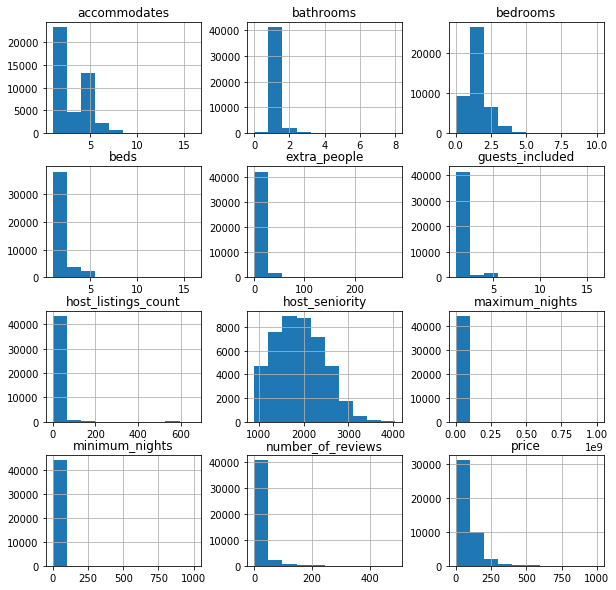

In [184]:
# Histograms
train[num_columns].hist(figsize=(10,10));

In [185]:
# Log+1 transformation
for col in num_columns:
    train[col] = train[col].astype('float64').replace(0.0, 1.0) # Replacing 0s with 0.1 so that we don't go to -inf
    train[col] = np.log(train[col])
    
    if col != "price":
        X_to_predict[col] = X_to_predict[col].astype('float64').replace(0.0, 1.0)
        X_to_predict[col] = np.log(X_to_predict[col])

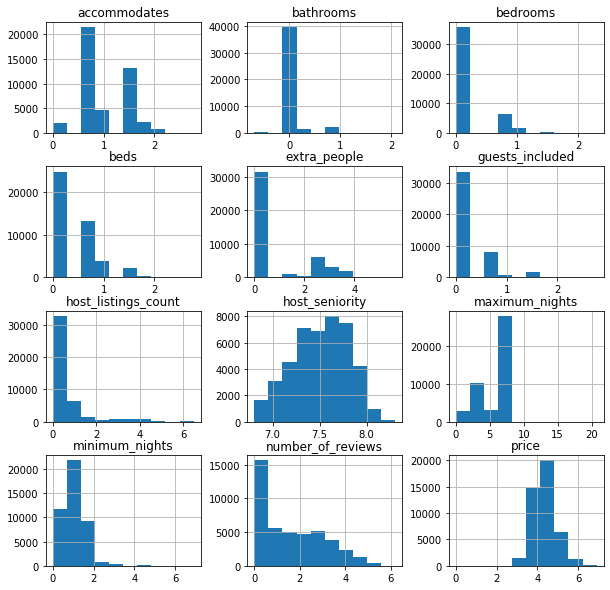

In [186]:
# Histograms again
train[num_columns].hist(figsize=(10,10));

We bell-shaped some of our variables (they might be closer to normality now).

#### first_review

In [187]:
# For train
train.first_review = pd.to_datetime(train.first_review)
train['days_since_first_review'] = (scrapping_date - train.first_review).astype('timedelta64[D]')
train.days_since_first_review.describe()

count    32924.000000
mean      1459.741040
std        435.179491
min        901.000000
25%       1132.000000
50%       1359.500000
75%       1666.000000
max       3692.000000
Name: days_since_first_review, dtype: float64

In [188]:
train.days_since_first_review = pd.cut(train.days_since_first_review, 
                                          bins=[0, 1094, 1459, 1665, train.days_since_first_review.max()], 
                                          labels=['0-3_years', '3-4_years', '4-4_5_years', '5+_years'],
                                          include_lowest=True)

train.days_since_first_review = train.days_since_first_review.astype('str')
train.days_since_first_review.replace('nan', 'unknown', inplace=True)
train.drop(columns=["first_review"], inplace=True)

In [189]:
# For X_to_predict
X_to_predict.first_review = pd.to_datetime(X_to_predict.first_review)
X_to_predict['days_since_first_review'] = (scrapping_date - X_to_predict.first_review).astype('timedelta64[D]')
X_to_predict.days_since_first_review.describe()

count    8207.000000
mean     1459.413306
std       435.019005
min       903.000000
25%      1128.000000
50%      1359.000000
75%      1663.000000
max      3558.000000
Name: days_since_first_review, dtype: float64

In [190]:
X_to_predict.days_since_first_review = pd.cut(X_to_predict.days_since_first_review, 
                                          bins=[0, 1094, 1459, 1665, X_to_predict.days_since_first_review.max()], 
                                          labels=['0-3_years', '3-4_years', '4-4_5_years', '5+_years'],
                                          include_lowest=True)

X_to_predict.days_since_first_review = X_to_predict.days_since_first_review.astype('str')
X_to_predict.days_since_first_review.replace('nan', 'unknown', inplace=True)
X_to_predict.drop(columns=["first_review"], inplace=True)

#### last_review

In fact the most recent last_review is from two years ago. This doesn't make sense so we will drop this column

In [191]:
train.drop(columns=["last_review"], inplace=True)

In [192]:
X_to_predict.drop(columns=["last_review"], inplace=True)

#### review scores

In [193]:
columns=['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
         'review_scores_communication', 'review_scores_location', 'review_scores_value']

We recall that we have plenty of missing values for these variables, so we will carry a similar approach as we did with host_response_rate

In [194]:
# For review_scores out of 10
for col in columns:
    train[col] = pd.cut(train[col], 
                        bins=[0, 9, 10],
                        labels=['0-9%', '10%'],
                        include_lowest=True)
    X_to_predict[col] = pd.cut(X_to_predict[col], 
                        bins=[0, 9, 10],
                        labels=['0-9%', '10%'],
                        include_lowest=True)
    
    train[col] = train[col].astype('str')
    X_to_predict[col] = X_to_predict[col].astype('str')
    
    train[col].replace('nan', 'unknown', inplace=True)
    X_to_predict[col].replace('nan', 'unknown', inplace=True)

    
# For review_scores out of 100 (review_scores_rating)
train.review_scores_rating = pd.cut(train.review_scores_rating, 
                                    bins=[0, 80, 95, 100],
                                    labels=['0-79%', '80-94%', '95-100'],
                                    include_lowest=True)
X_to_predict.review_scores_rating = pd.cut(X_to_predict.review_scores_rating, 
                                           bins=[0, 80, 95, 100],
                                           labels=['0-79%', '80-94%', '95-100'],
                                           include_lowest=True)
    
train.review_scores_rating = train.review_scores_rating.astype('str')
X_to_predict.review_scores_rating = X_to_predict.review_scores_rating.astype('str')
    
train.review_scores_rating.replace('nan', 'unknown', inplace=True)
X_to_predict.review_scores_rating.replace('nan', 'unknown', inplace=True)

#### cancellation_policy

In [195]:
train.cancellation_policy.value_counts()

flexible           16316
strict             15169
moderate           12698
super_strict_60        8
super_strict_30        5
Name: cancellation_policy, dtype: int64

The categories super_strict_60 and super_strict_30 have too few observations... We will group them with the closest policy, which is strict.

In [196]:
# Let's do some replacement
dic = {"super_strict_60": "strict",
       "super_strict_30": "strict"}

train.replace({"cancellation_policy": dic}, inplace=True)
X_to_predict.replace({"cancellation_policy": dic}, inplace=True)

#### features

In [197]:
train.features.head(3) # for every property, we have a list of all its features

id
10534791                           Host Has Profile Pic
16001259                           Host Has Profile Pic
17763072    Host Has Profile Pic,Host Identity Verified
Name: features, dtype: object

This is interesting, as it gives a lot of information on the host verified by Aribnb, and some requirements for the user when booking. We will use a similar approach as we did with amenities.

In [198]:
print("The training dataset has", train.features.isna().sum(), "missing values")
print("The test dataset has", X_to_predict.features.isna().sum(), "missing values")

The training dataset has 16 missing values
The test dataset has 3 missing values


In [199]:
mode = train.features.value_counts().keys()[0]
train.features.fillna(mode, inplace=True)

mode = X_to_predict.features.value_counts().keys()[0]
X_to_predict.features.fillna(mode, inplace=True)

In [200]:
def treat_features(df: pd.DataFrame) -> pd.DataFrame:
    """Treats the features variable.
    Transforms every feature into a new column, making sure class-imbalance constraint
    is not violated. (i.e. keep those that appear in 10%-90% of the listings).

    Args:
        df (pd.DataFrame): dataframe containing features
    Return:
        df (pd.DataFrame): dataframe with features decomposed
    """
    if "features" not in list(df.columns):
        return df

    # Giant list
    features_list = list(df.features)
    features_list_string = ",".join(features_list) # giant string
    features_splitted = features_list_string.split(',')
    features_set = set(features_splitted) # we keep unique values
    
    # Frequency for every feature
    frequencies_dict = {}
    for i in features_set:
        frequencies_dict[i] = features_splitted.count(i) / len(features_list) * 100

    # We convert to list of tuples to sort
    print("The features sorted by frequency are: \n", sorted(frequencies_dict.items(), key=lambda k: k[1]))
    
    # We will keep all those that appear in no more than 90% nor less than 10% of the listings:
    uninteresting_features = []
    for i in frequencies_dict:
        if frequencies_dict[i] <= 10 or frequencies_dict[i] >= 90:
            uninteresting_features.append(i)

    print("\nThere are", len(uninteresting_features), "uninteresting_features.")

    features_set -= set(uninteresting_features)
    print("\nThe final set is of length", len(features_set),":", features_set)
    
    # new columns
    for i in features_set:
        df[get_new_name(i)] = np.where(df["features"].str.contains(i), 1, 0)
    
    # we can drop the origianl column
    df.drop(columns=['features'], inplace=True)
    
    return(df)

In [201]:
train = treat_features(train)
X_to_predict = treat_features(X_to_predict)

The features sorted by frequency are: 
 [('Require Guest Profile Picture', 1.4232057199746584), ('Require Guest Phone Verification', 2.6178839714001265), ('Host Is Superhost', 5.552538691284279), ('Instant Bookable', 21.651280658883156), ('Host Identity Verified', 54.6022264458322), ('Is Location Exact', 86.7544574169608), ('Host Has Profile Pic', 99.6176124536157)]

There are 4 uninteresting_features.

The final set is of length 3 : {'Instant Bookable', 'Host Identity Verified', 'Is Location Exact'}
The features sorted by frequency are: 
 [('Require Guest Profile Picture', 1.40547492191806), ('Require Guest Phone Verification', 2.581297078816829), ('Host Is Superhost', 5.4565496968583505), ('Instant Bookable', 21.37607936799559), ('Host Identity Verified', 54.52875252618041), ('Is Location Exact', 86.99246738930736), ('Host Has Profile Pic', 99.6417416865699)]

There are 4 uninteresting_features.

The final set is of length 3 : {'Instant Bookable', 'Host Identity Verified', 'Is Locati

## 2.3  Creating new features

#### descrip_mentions_pt (description mentions public transport)

In [7]:
def detect_pt(df: pd.DataFrame) -> list:
    """Detects if the listing description mentions any form of public transport.

    Args:
        df (pd.DataFrame): dataframe containing descriptions
    Return:
        list: new binary variable (1 if public transport mentioned, 0 if not). 
    """
    descrip_mentions_pt = []
    words_to_look_for = ["metros", "undergrounds", "subways", "tubes", "lignes", "lines", 
                     "stations", "arrets", "stops", "bus", "ratp", "transports"]

    for i in range(len(df)):
        descrip = df.description.iloc[i]
        if type(descrip) == str:
            descrip = unidecode.unidecode(descrip.lower())
            word_found = False
            for j in words_to_look_for:
                if (j in descrip) or (stem(j) in descrip):
                    word_found = True
            if word_found == True:
                descrip_mentions_pt.append(1)
            else:
                descrip_mentions_pt.append(0)
        else:
            descrip_mentions_pt.append(0)
            
    return descrip_mentions_pt

In [203]:
train["descrip_mentions_pt"] = detect_pt(train)
X_to_predict["descrip_mentions_pt"] = detect_pt(X_to_predict)

train.drop(columns=["description"], inplace=True)
X_to_predict.drop(columns=["description"], inplace=True)

#### sum of distances to monuments

In [853]:
coordinates = pd.read_csv("paris_monuments.csv", sep=";")
coordinates.set_index("monument", inplace=True)
coordinates.head()

,latitude,longitude,weight
monument,,,
eiffel tower,48.8584,2.2945,201433
louvre museum,48.8606,2.3376,177105
notre dame,48.8530,2.3499,42060
arc de triomphe,48.8738,2.2950,123933
sacre coeur,48.8867,2.3431,72946


In [854]:
def dist_btw_coordinates(lat1, lon1, lat2, lon2): 
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6373.0 * c
    return(distance)

In [855]:
def compute_list_dist(listing_lat, listing_long, df):
    list_dists = list()
    for i in range(len(df)):
        lat2 = df.iloc[i].latitude
        lon2 = df.iloc[i].longitude
        weight = df.iloc[i].weight
        list_dists.append(dist_btw_coordinates(listing_lat, listing_long, lat2, lon2)*weight)
    return(np.array(list_dists).sum())

In [856]:
def sum_distances_for_df(df):
    list_distances = []
    for i in range(len(df)):
        listing_lat = df.latitude_airbnb.iloc[i]
        listing_long = df.longitude_airbnb.iloc[i]
        list_distances.append(np.sum(compute_list_dist(listing_lat, listing_long, coordinates)))
    return(list_distances)

In [857]:
train["monument_distances"] = sum_distances_for_df(train)
X_to_predict["monument_distances"] = sum_distances_for_df(X_to_predict)

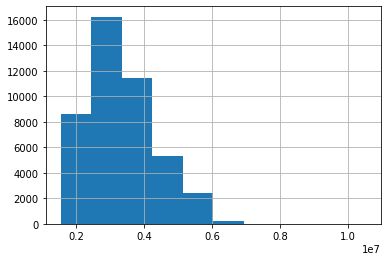

In [858]:
train.monument_distances.hist();

#### distance to the center

In [859]:
def distances_to_center(df):
    lat_center = 48.856600
    lon_center = 2.352200
    list_distances = []
    for i in range(len(df)):
        listing_lat = df.latitude_airbnb.iloc[i]
        listing_long = df.longitude_airbnb.iloc[i]
        list_distances.append(dist_btw_coordinates(lat_center, lon_center, listing_lat, listing_long))
    return(list_distances)

In [860]:
train["distance_to_center"] = distances_to_center(train)
X_to_predict["distance_to_center"] = distances_to_center(X_to_predict)

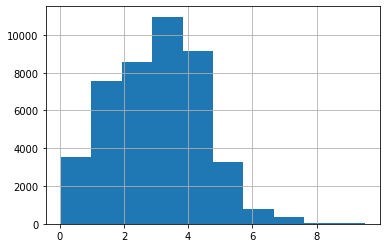

In [861]:
train.distance_to_center.hist();

#### subway_distances

In [862]:
metros = pd.read_csv("metro_stations.csv", sep=";")
metros.set_index("station", inplace=True)
metros.head(3)

,latitude,longitude,nb_visiteurs,weight
station,,,,
gare du nord,48.881154,2.357913,49721477,0.134826
saint lazare,48.875376,2.325810,45666162,0.123829
garde de lyon,48.844895,2.371529,34971365,0.094829


In [863]:
def min_distance(df):
    list_distances = []
    for i in range(len(df)):
        listing_lat = df.latitude_airbnb.iloc[i]
        listing_long = df.longitude_airbnb.iloc[i]
        list_distances.append(np.min(compute_list_dist(listing_lat, listing_long, metros)))
    return(list_distances)

In [864]:
train["distance_to_closest_station"] = min_distance(train)
X_to_predict["distance_to_closest_station"] = min_distance(X_to_predict)

In [865]:
# dropping unnecessary columns
train.drop(columns=["latitude_airbnb"], inplace=True)
X_to_predict.drop(columns=["latitude_airbnb"], inplace=True)

train.drop(columns=["longitude_airbnb"], inplace=True)
X_to_predict.drop(columns=["longitude_airbnb"], inplace=True)

# 4. Models

## 4.0 Model preparation

In [204]:
# removing [, ] or < from column names
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in train.columns.values]
X_to_predict.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_to_predict.columns.values]

# Separating X and y
X = train.drop('price', axis=1)
y = train.price

### Encoding categorical variables
The goal here is to transform categorical variables into numerical so that they are suitable to be used in machine learning techniques. After some research, I realized there are many ways to encode, adapted to different kinds of issues such as high cardinality, ordered or nominal, etc. <br>
In our case we don't have any variable with a lot of modalities (more than 1000) so we don't need to worry about high cardinality issues, but we still have some categorical feautres that seem really important to determine the price, so we must still be careful if we want to do it right. Plus after all the cleaning we did it would be a pitty to waste the job! <br>
The thing is that many articles in the litterature have shown that the type of encoding that we use should depend on the type of model that we intend to implement. For instance, some boosting models (such as CatBoost) are able to operate with categorical features directly, whereas neural networks or linear models require these features to be previously transformed to a numerical version (one dummy for every modality, for instance). Besides, for a tree-based model, **some papers suggest that a single level of a one-hot-encoded categorical variable must have a very high importance score (which is measured by how much it decreases tree impurity) in order to be selected for splitting at an early stage (i.e. closer to the root), over a continuous variable**. (And so, because continuous variables would be more likely to be selected from the beggining, it could happen that the subsequent branches are impure and that even if we include categorical features at a later stage, it is already too late for obtianing an optimal performance...).

Taking all this into account, in what follows we will: ordinally encode multinomial **hierarchical** categorical features, one-hot encode simple ones (0 or 1), or keep categorical features for CatBoost (which will use one_hot_max_size encoding itself).

In [205]:
# One-Hot encoding
X = pd.get_dummies(X, columns=['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type',
                               'cancellation_policy'])
X_to_predict = pd.get_dummies(X_to_predict, columns=['neighbourhood_cleansed', 'property_type', 'room_type', 
                                                     'bed_type', 'cancellation_policy'])

In [ ]:
## Label encoding
le = LabelEncoder()
cols_to_label = ['host_response_time', 'host_response_rate', 'security_deposit', 'cleaning_fee',
                 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'days_since_first_review']

X[cols_to_label] = X[cols_to_label].apply(lambda col: le.fit_transform(col))
X_to_predict[cols_to_label] = X_to_predict[cols_to_label].apply(lambda col: le.fit_transform(col))

### Scaling

In [210]:
# Standard scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
X_to_predict = pd.DataFrame(scaler.transform(X_to_predict), columns=list(X_to_predict.columns))

In [211]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Useful functions

In [212]:
# Function to evaluate model performances
def model_evaluation(model, X_train, X_test, y_test):
    predicted_train = np.exp(model.predict(X_train.values))
    predicted_test = np.exp(model.predict(X_test.values))
    train_RMSE = round(np.sqrt(mean_squared_error(np.exp(y_train), predicted_train)), 4)
    validation_RMSE = round(np.sqrt(mean_squared_error(np.exp(y_test), predicted_test)), 4)
    print("Training RMSE:", train_RMSE)
    print("Validation RMSE:", validation_RMSE)
    if train_RMSE < validation_RMSE:
        print("We overfit...")
    else:
        print("We don't overfit!")
    return((train_RMSE, validation_RMSE))

In [213]:
# Preparing for submission
def create_csv(kaggle_prediction):
    csvData = [['Id', 'Predicted']]
    for i, j in zip(range(len(indices)), range(len(kaggle_prediction))):
        csvData.append([indices[i], kaggle_prediction[j]])
    
    with open('submission_airbnb.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(csvData)
    csvFile.close()

## 4.1. XGBoost

For the past recent years, XGBoost has been the king algorithm delivering fast and high performance for regression problems.

### 4.1.1 First run

In [214]:
# Model
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror",
                           nthread=4,
                           seed=1139)
xgb_reg.fit(X_train.values, y_train.values)

# Prediction results
(train_RMSE, validation_RMSE) = model_evaluation(xgb_reg, X_train, X_test, y_test)
first_RMSE = train_RMSE

Training RMSE: 44.9145
Validation RMSE: 45.4166
We overfit...


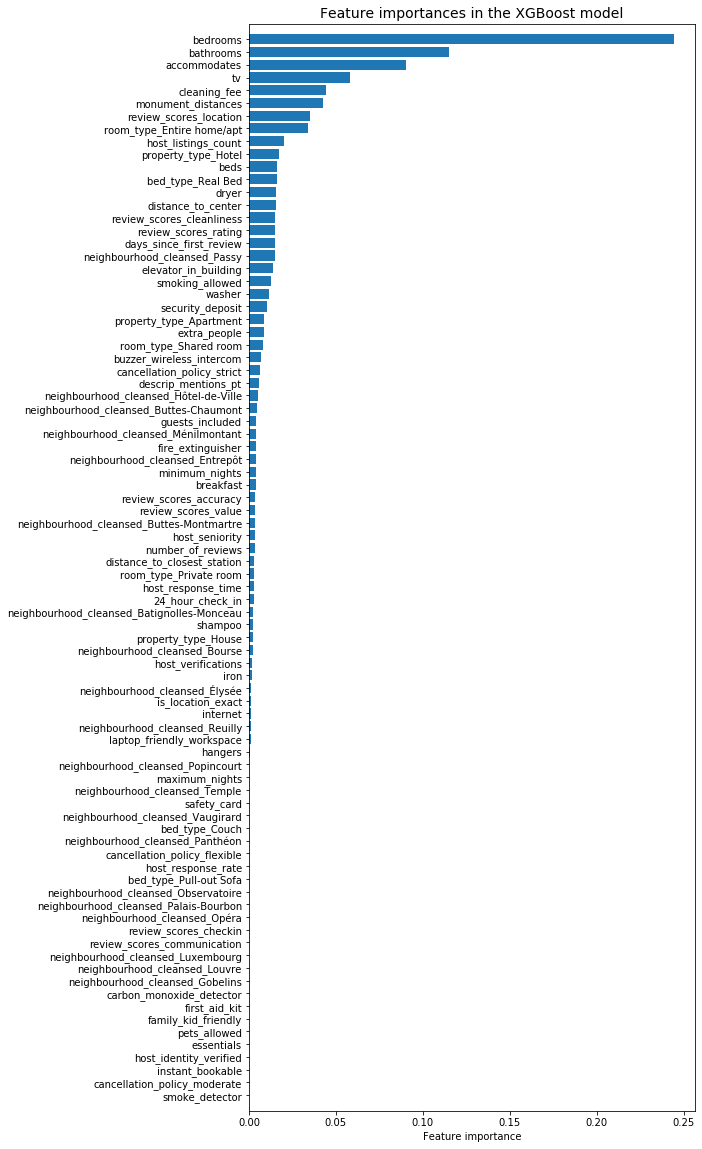

In [610]:
# Feature importances
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

### 4.1.2 Simple parameter tunning using $k$-fold CV ($k$=5)

General parameters:
* booster (default: gbtree): type of model. Default gbtree performs always better than gblinear.
* seed: used for reproducible results, useful for parameter tunning.
* nthread: number of cores in the system, useful for parallel computing

Parameters we will tune:
* n_estimators: number of trees to fit
* max_depth: maximum depth of a tree. Will be used to control over-fitting (higher depth => more specific tree).
* eta (i.e. learning rate): how much do we retain from weights of previous step at every new step.
* min_child_weight:  minimum sum of weights (of all observations) required in a child. Will be used to control over-fitting
* subsample (default 1): fraction of observations to be randomly sampled for each tree. Will be used to control over-fitting.
* colsample_bytree (default=1): similar to max_features in GBM: fraction of columns to be randomly sampled for each tree.

Other parameters redundant with what we already used (max_leaf_nodes, colsample_bylevel) or for which default value is okay (gamma, max_delta_step, etc.) won't be included.

In order to tune correctly, we will first tune the parameters that might have higher impact on the model performance. Ordered, these are: number of trees, max_depth and min_child_weight. Once those are fixed, we will tune the rest.

In [611]:
# Step 1: Optimal n_estimators

# We start by fixing the rest
xgb1 = xgb.XGBRegressor(
    n_estimators=1000,
    eta=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'reg:squarederror',
    nthread=4,
    seed=1139)

# Optimal nb_trees
xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
cv_folds = 5
cvresult = xgb.cv(xgb1.get_xgb_params(), 
                  xgtrain, 
                  num_boost_round = xgb1.get_xgb_params()['n_estimators'], 
                  nfold = cv_folds, 
                  early_stopping_rounds = 50)
# num_boost_round: Number of boosting iterations (number of trees)
# early_stopping_rounds=50: RMSE (CV metric) needs to improve at least once in 50 round to continue training

opt_n_estimators = cvresult.shape[0]
print("We obtained an optimal number of estimators of", opt_n_estimators, "for a learning rate of 0.1.")
xgb1.set_params(n_estimators = opt_n_estimators);

We obtained an optimal number of estimators of 420 for a learning rate of 0.1.


In [1]:
# Step 2: Optimal max_depth and min_child_weight (this can take some time)

# A) Wider ranges at first
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=opt_n_estimators,
                                                     eta=0.1,
                                                     max_depth=5,
                                                     min_child_weight=1, 
                                                     subsample=0.8, 
                                                     colsample_bytree=0.8,
                                                     objective='reg:squarederror', 
                                                     nthread=4, 
                                                     seed=1139),
                        param_grid = param_test1,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = -1,
                        cv = 5)

gsearch1.fit(X_train.values, y_train.values)
print("Best parameters: ", gsearch1.best_params_, "\nBest RMSE", round((-gsearch1.best_score_)**(0.5), 4))

opt_max_depth = gsearch1.best_params_['max_depth']
opt_min_child_weight = gsearch1.best_params_['min_child_weight']

NameError: name 'GridSearchCV' is not defined

In [ ]:
# Step 2: Optimal max_depth and min_child_weight (this can take some time)

# B) Narrowing the range
param_test2 = {
 'max_depth':[opt_max_depth-1, opt_max_depth, opt_max_depth+1],
 'min_child_weight':[opt_min_child_weight-1, opt_min_child_weight, opt_min_child_weight+1]
}

gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=opt_n_estimators,
                                                     eta=0.1, 
                                                     max_depth=opt_max_depth,
                                                     min_child_weight=opt_min_child_weight, 
                                                     subsample=0.8, 
                                                     colsample_bytree=0.8,
                                                     objective='reg:squarederror', 
                                                     nthread=4,
                                                     seed=1139), 
                        param_grid = param_test2, 
                        scoring = 'neg_mean_squared_error',
                        n_jobs = -1, 
                        cv = 5)

gsearch2.fit(X_train.values, y_train.values)
print("Best parameters: ", gsearch2.best_params_, "\nBest RMSE", round((-gsearch2.best_score_)**(0.5), 4))

opt_max_depth = gsearch2.best_params_['max_depth']
opt_min_child_weight = gsearch2.best_params_['min_child_weight']

### 4.1.4 More extensive parameter tuning

In [168]:
# Step 3: Tune subsample and colsample_bytree

# A) Wider ranges at first
param_test3 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=opt_n_estimators,
                                                     eta=0.1,
                                                     max_depth=opt_max_depth,
                                                     min_child_weight=opt_min_child_weight,
                                                     subsample=0.8,
                                                     colsample_bytree=0.8,
                                                     objective='reg:squarederror',
                                                     nthread=4,
                                                     seed=1139),
                        param_grid = param_test3,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = -1,
                        cv = 5)

gsearch3.fit(X_train.values, y_train.values)
print("Best parameters: ", gsearch3.best_params_, "\nBest RMSE", round((-gsearch3.best_score_)**(0.5), 4))

opt_subsample = gsearch3.best_params_['subsample']
opt_colsample_bytree = gsearch3.best_params_['colsample_bytree']

Best parameters:  {'colsample_bytree': 0.7, 'subsample': 0.9} 
Best RMSE 0.2993


In [169]:
# Step 3: Tune subsample and colsample_bytree

# B) Narrowing the range
param_test4 = {
    'subsample':[i/100.0 for i in range(int(opt_subsample*100)-5, int(opt_subsample*100)+10, 5)],
    'colsample_bytree':[i/100.0 for i in range(int(opt_colsample_bytree*100)-5, int(opt_colsample_bytree*100)+10, 5)]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=opt_n_estimators,
                                                     eta=0.1,
                                                     max_depth=opt_max_depth,
                                                     min_child_weight=opt_min_child_weight,
                                                     subsample=opt_subsample, 
                                                     colsample_bytree=opt_colsample_bytree,
                                                     objective= 'reg:squarederror',
                                                     nthread=4,
                                                     seed=1139), 
                        param_grid = param_test4,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = -1,
                        cv = 5)

gsearch4.fit(X_train.values, y_train.values)

print("Best parameters: ", gsearch4.best_params_, "\nBest RMSE", round((-gsearch4.best_score_)**(0.5), 4))

opt_subsample = gsearch4.best_params_['subsample']
opt_colsample_bytree = gsearch4.best_params_['colsample_bytree']

Best parameters:  {'colsample_bytree': 0.7, 'subsample': 0.9} 
Best RMSE 0.2993


### 4.1.4 Last run: optimized parameters

In [216]:
opt_n_estimators = 513
opt_min_child_weight = 4
opt_max_depth = 5
opt_subsample = 0.9
opt_colsample_bytree = 0.7
opt_reg_alpha = 1

In [217]:
##### Model
xgb_reg = xgb.XGBRegressor(n_estimators=opt_n_estimators,
                           eta=0.1,
                           max_depth=opt_max_depth,
                           min_child_weight=opt_min_child_weight,
                           subsample=opt_subsample, 
                           colsample_bytree=opt_colsample_bytree,
                           objective= 'reg:squarederror',
                           gamma=0,
                           nthread=4,
                           seed=1139)
xgb_reg.fit(X_train.values, y_train.values)

# Prediction results
(train_RMSE, validation_RMSE) = model_evaluation(xgb_reg, X_train, X_test, y_test)
last_RMSE = validation_RMSE

print("Before parameter tunning we had a validation RMSE of", first_RMSE, 
      "and after parameter tunning an RMSE of", last_RMSE,
      "which is a (substantial!) gain of",  round((first_RMSE - last_RMSE) / first_RMSE * 100, 2), "%.")

Training RMSE: 32.9482
Validation RMSE: 42.4797
We overfit...
Before parameter tunning we had a validation RMSE of 44.9145 and after parameter tunning an RMSE of 42.4797 which is a (substantial!) gain of 5.42 %.


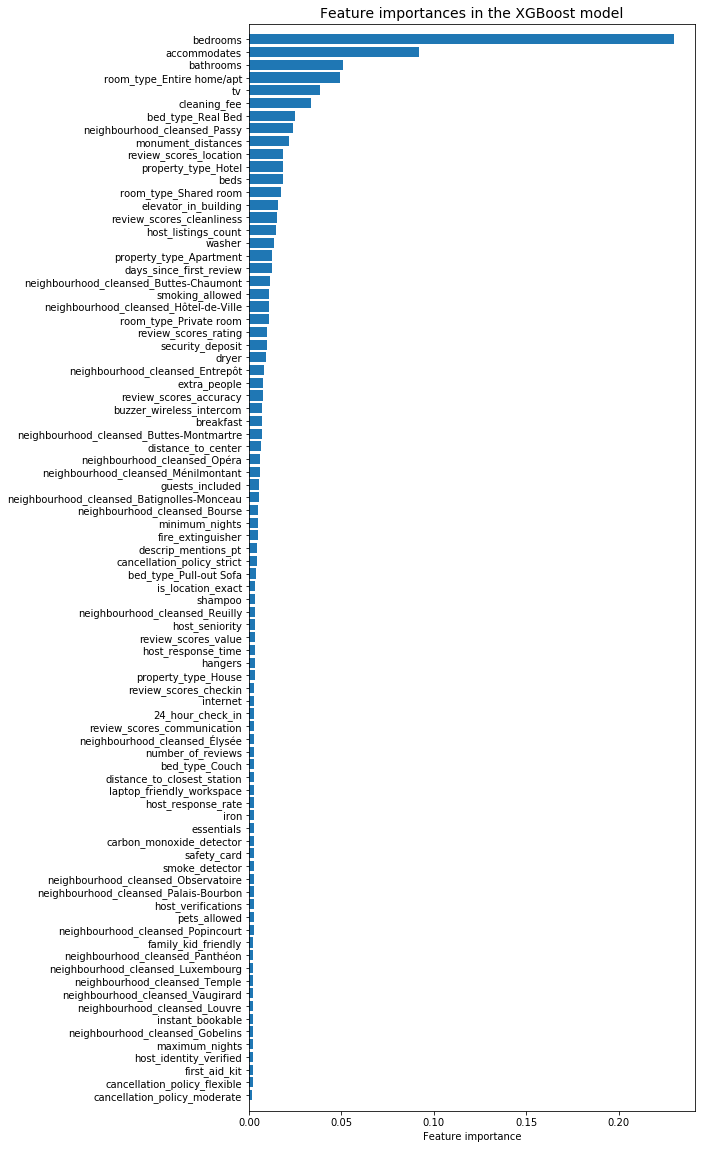

In [614]:
# Feature importances
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [97]:
# Kaggle prediction
kaggle_prediction = np.round(np.exp(xgb_reg.predict(X_to_predict.values)), 1)
create_csv(kaggle_prediction)

## 4.2 CatBoost

CatBoost was launched in 2017 by a Russian tech company. The way it treats categorical variables has made it more efficient than XGBoost in some situations. Let's see if it's also the case for our problem. <br>
We need to rerun from the beggining of the model part and not encode the categorical features, nor scale any feature.

General parameters:
* thread_count: number of cores in the system, useful for parallel computing
* random_seed: used for reproducible results, useful for parameter tunning.

Parameters we will "tune":
* iterations(default=1000): maximum number of trees that can be built (too high can lead to overfitting).
* learning_rate (default=0.02999999933): how much do we retain from weights of previous step at every new step.
* depth(default=6): maximum depth of a tree. Will be used to control over-fitting (higher depth => more specific tree).
* l2_leaf_reg (default=3): l2 regularization. Will be used to control over-fitting.
* one_hot_max_size (default=2): uses one-hot encoding for all features with number of modaltiies less than or equal to the value
* rsm (default=1): previous colsample_bytree: fraction of columns to be randomly sampled for each tree.

Here we don't have parameter to subset data (subsample), nor min_child_weight.

Here we will try different values for our parameters manually not to be super extensive. We will first "tune" the parameters that might have higher impact on the model performance.

In [890]:
# BEST model
categ_features = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy',
                  'host_response_time', 'host_response_rate', 'security_deposit', 'cleaning_fee',
                  'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                  'review_scores_communication', 'review_scores_location', 'review_scores_value', 'days_since_first_review']
cat_reg = cb.CatBoostRegressor(n_estimators=2000,
                               learning_rate=0.07,
                               depth=7,
                               l2_leaf_reg=3,
                               one_hot_max_size=10,
                               rsm=1,
                               loss_function='RMSE',
                               cat_features=categ_features,
                               silent=True,
                               thread_count=-1,
                               random_seed=1139)

cat_reg.fit(X_train, y_train)
# Prediction results
(train_RMSE, validation_RMSE) = model_evaluation(cat_reg, X_train, X_test, y_test)
first_RMSE = train_RMSE

Training RMSE: 19.5855
Validation RMSE: 41.8872
We overfit...


## Experimental results:

##### for learning_rate=0.02 
* depth=6 / l2_leaf_reg=3 / one_hot_max_size=2 / rsm=1 => (train_RMSE=39.5588, validation_RMSE=42.4739)
* depth=5 / l2_leaf_reg=3 / one_hot_max_size=2 / rsm=1 => (train_RMSE=40.6128, validation_RMSE=42.6497)
* depth=7 / l2_leaf_reg=3 / one_hot_max_size=2 / rsm=1 => (train_RMSE=38.2708, validation_RMSE=42.3555)
* depth=8 / l2_leaf_reg=3 / one_hot_max_size=2 / rsm=1 => (train_RMSE=, validation_RMSE=42.4516)
* depth=9 / l2_leaf_reg=3 / one_hot_max_size=2 / rsm=1 => (train_RMSE=34.9649, validation_RMSE=42.4501)
* depth=7 / l2_leaf_reg=3 / one_hot_max_size=4 / rsm=1 => (train_RMSE=37.4872, validation_RMSE=42.1436)
* **depth=7 / l2_leaf_reg=3 / one_hot_max_size=6 / rsm=1 => (train_RMSE=37.2428, validation_RMSE=42.0587)**
* depth=7 / l2_leaf_reg=2 / one_hot_max_size=10 / rsm=1 => (train_RMSE=36.8441, validation_RMSE=42.1261)
* depth=7 / l2_leaf_reg=4 / one_hot_max_size=10 / rsm=1 => (train_RMSE=37.5851, validation_RMSE=42.1562)
* depth=7 / l2_leaf_reg=3 / one_hot_max_size=10 / rsm=0.8 => (train_RMSE=37.5851, validation_RMSE=42.1562)
* depth=7 / l2_leaf_reg=3 / one_hot_max_size=10 / rsm=0.9 => (train_RMSE=37.2537, validation_RMSE=42.1163)

##### for depth=7 / l2_leaf_reg=3 / one_hot_max_size=6 / rsm=1
* learning_rate=0.1 => (validation_RMSE=41.9004)
* learning_rate=0.9 => (validation_RMSE=41.7309)
* learning_rate=0.08 => (validation_RMSE=41.705)
* learning_rate=0.07 => (validation_RMSE=41.5497)
* learning_rate=0.06 => (validation_RMSE=41.874)
* learning_rate=0.075 => (validation_RMSE=41.9169)
* learning_rate=0.065 => (validation_RMSE=41.5746)

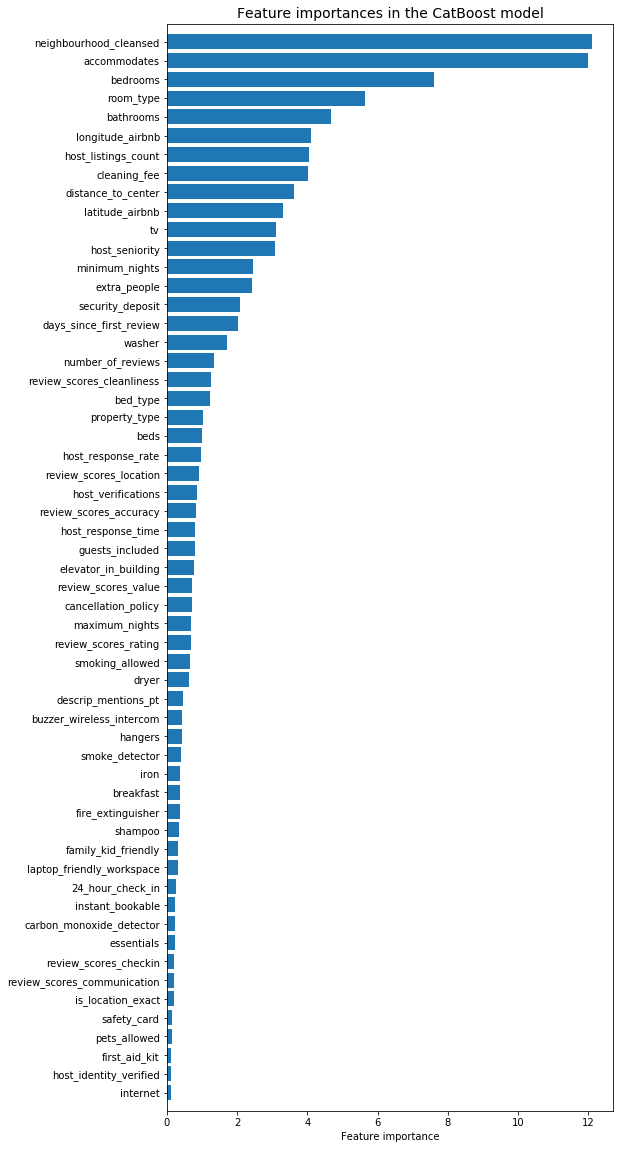

In [757]:
# Feature importances
ft_weights_cat_reg = pd.DataFrame(cat_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_cat_reg.sort_values('weight', inplace=True)
plt.figure(figsize=(8,20))
plt.barh(ft_weights_cat_reg.index, ft_weights_cat_reg.weight, align='center') 
plt.title("Feature importances in the CatBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [889]:
# Kaggle prediction
kaggle_prediction = np.round(np.exp(cat_reg.predict(X_to_predict)), 1)
create_csv(kaggle_prediction)

## 4.3 Neural Network

In [770]:
### Building the simple nn
nn = Sequential()
nn.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn.add(Dense(256, activation='relu'))
nn.add(Dense(256, activation='relu'))
nn.add(Dense(1, activation='linear'))

# Compiling the model
nn.compile(loss='mean_squared_error',
            optimizer="adam",
            metrics=['mean_squared_error'])

# Model summary
print(nn.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               10880     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 109,953
Trainable params: 109,953
Non-trainable params: 0
_________________________________________________________________
None


In [771]:
# Training the model
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1)
nn_history = nn.fit(X_train.values,
                    y_train.values,
                    batch_size=256,
                    epochs=100,
                    verbose=0,
                    callbacks=[early_stopping],
                    validation_split=0.1)

(train_RMSE, validation_RMSE) = model_evaluation(nn, X_train, X_test, y_test)

Epoch 00028: early stopping
Training RMSE: 30.166
Validation RMSE: 50.2658
We overfit...


In [772]:
# Again we have tunned manually. Below is the best model and the results from experimental trials.

## Experimental results: (100 epochs)

* 4 layers (128, 256, 256, 1) / no regularization / no batchnormalization / default adam / batch_size=256 => (train_RMSE=0.2203, validation_RMSE=0.3672)
* 4 layers (128, 256, 256, 1) / dropout=0.2 / no batchnormalization / default adam / batch_size=256 => (train_RMSE=0.2933, validation_RMSE=0.3618)
* 4 layers (128, 256, 256, 1) / dropout=0.2 / batchnormalization / default adam / batch_size=256 => (train_RMSE=0.2795, validation_RMSE=0.3266)
* 4 layers (128, 256, 256, 1) / dropout=0.3 / batchnormalization / default adam / batch_size=256 => (train_RMSE=0.2762, validation_RMSE=0.3177)
* 4 layers (128, 256, 256, 1) / dropout=0.4 / batchnormalization / default adam / batch_size=256 => (train_RMSE=0.2686, validation_RMSE=0.314)
* **4 layers (128, 256, 256, 1) / dropout=0.4 / batchnormalization / custom adam / batch_size=256 => (train_RMSE=0.2716, validation_RMSE=0.3123)**
* 4 layers (128, 256, 256, 1) / dropout=0.45 / batchnormalization / custom adam / batch_size=256 => (train_RMSE=0.2815, validation_RMSE=0.3154)
* 4 layers (128, 256, 256, 1) / l1=0.005 / batchnormalization / custom adam / batch_size=256 => (train_RMSE=0.3167, validation_RMSE=0.3231)
* 4 layers (128, 256, 256, 1) / l2=0.01 / batchnormalization / custom adam / batch_size=256 => (train_RMSE=0.6249, validation_RMSE=0.6274)
* 4 layers (128, 256, 256, 1) / l2=0.02 / batchnormalization / custom adam / batch_size=256 => (train_RMSE=0.3296, validation_RMSE=0.3391)
* 4 layers (128, 256, 256, 1) / l2=0.03 / batchnormalization / custom adam / batch_size=256 => (train_RMSE=0.462, validation_RMSE=0.4765)
* 5 layers (128, 256, 256, 256, 1) / dropout=0.4 / batchnormalization / custom adam / batch_size=256 => (train_RMSE=0.2795, validation_RMSE=0.3182)
* 5 layers (128, 256, 256, 512, 1) / dropout=0.4 / batchnormalization / custom adam / batch_size=256 => (train_RMSE=0.2918, validation_RMSE=0.3253)
* 4 layers (128, 256, 256, 1) / dropout=0.4 / batchnormalization / custom adam / batch_size=128 => (train_RMSE=0.265, validation_RMSE=0.3135)
* 4 layers (128, 256, 256, 1) / dropout=0.4 / batchnormalization / custom adam / batch_size=512 => (train_RMSE=0.3047, validation_RMSE=0.3227)
* 4 layers (64, 128, 256, 1) / dropout=0.4 / batchnormalization / custom adam / batch_size=512 => (train_RMSE=0.3047, validation_RMSE=0.3227)
* 3 layers (128, 256, 1) / dropout=0.4 / batchnormalization / custom adam / batch_size=512 => (train_RMSE=0.2885, validation_RMSE=0.3214)

In [773]:
### BEST Neural Network
nn = Sequential()
nn.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn.add(Dropout(rate=0.4))
nn.add(BatchNormalization())

nn.add(Dense(256, activation='relu'))
nn.add(Dropout(rate=0.4))
nn.add(BatchNormalization())

nn.add(Dense(256, activation='relu'))
nn.add(Dropout(rate=0.4))
nn.add(BatchNormalization())

nn.add(Dense(1, activation='linear'))

# Compiling the model
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
nn.compile(loss='mean_squared_error',
            optimizer=adam,
            metrics=['mean_squared_error'])

# Model summary
# print(nn.summary())

# Training the model
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1)
nn_history = nn.fit(X_train.values,
                    y_train.values,
                    batch_size=256,
                    epochs=100,
                    verbose=0,
                    callbacks=[early_stopping],
                    validation_split=0.1)

(train_RMSE, validation_RMSE) = model_evaluation(nn, X_train, X_test, y_test)

Training RMSE: 38.8206
Validation RMSE: 43.0416
We overfit...
